# Music genre prediction

**Описание задачи**

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы пройдите все основные этапы полноценного исследования:

*  загрузка и ознакомление с данными
*  предварительная обработка
*  полноценный разведочный анализ
*  разработка новых синтетических признаков
*  проверка на мультиколлинеарность
*  отбор финального набора обучающих признаков
*  выбор и обучение моделей
*  итоговая оценка качества предсказания лучшей модели
*  анализ важности ее признаков

**ВАЖНО**  
Необходимо реализовать решение с использованием технологии `pipeline` (из библиотеки `sklearn`)

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ**

* Оформленный репозиторий на GitHub (ноутбук с исследованием + код приложения)
* Развернутое web-приложение (с использованием библиотеки Streamlit)

## Участники проекта, репозиторий, приложение

Участники проекта: Анастасия Горевалова, Анна Булкина, Наталья Джога 

Сслылка на репозиторий: https://github.com/gorevalova/DS13_ML2

## Импорт библиотек, установка констант

In [2]:
%%capture
!pip install catboost -q
!pip install association-metrics
!pip install category_encoders -q
!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostRegressor

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [31]:
# Путь к датасетам: 
TRAIN = "https://www.dropbox.com/scl/fi/5zy935lqpaqr9lat76ung/music_genre_train.csv?rlkey=ccovu9ml8pfi9whk1ba26zdda&dl=1"
TEST = "https://www.dropbox.com/scl/fi/o6mvsowpp9r3k2lejuegt/music_genre_test.csv?rlkey=ac14ydue0rzlh880jwj3ebum4&dl=1"

In [32]:
# Установка констант:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и обзор данных

In [33]:
# Чтение файлов с исходными датасетами:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [34]:
# Выводим первые 5 случайных строк тренировочной выборки:
train.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
14547,36209.0,Arcus,0.2620,0.374,201600.0,0.886,0.000985,B,0.0919,-4.004,Minor,0.0613,150.082,4-Apr,0.1130,Electronic
18578,44420.0,Groovy Discotech,0.6390,0.642,95440.0,0.438,0.446000,C#,0.1130,-14.543,Major,0.0366,120.250,4-Apr,0.0752,Anime
5387,74257.0,Her Diamonds,0.0159,0.555,280000.0,0.924,0.000000,G,0.0750,-4.930,Major,0.0604,87.606,4-Apr,0.8650,Rock
16529,77652.0,Night Time Is the Right Time,0.8160,0.617,199627.0,0.773,0.000000,F,0.6320,-6.557,Minor,0.0636,78.729,4-Apr,0.6940,Jazz
10088,90253.0,U're Mine,0.7170,0.689,138031.0,0.147,0.896000,F,0.0942,-20.000,Minor,0.0366,100.086,4-Apr,0.2680,Rap


In [35]:
# Выводим первые 5 случайных строк тестовой выборки:
test.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
2855,30593,Carnival of Rust,0.2250,0.492,262947.0,0.590,0.000028,F,0.0973,-4.593,Minor,0.0239,91.018,4-Apr,0.124
3113,22863,Work For You (feat. Kaz Moon),0.3120,0.783,182320.0,0.700,0.000125,D,0.1130,-7.138,Major,0.0605,130.040,4-Apr,0.395
260,49180,GODZILLA TITLE / [GODZILLA],0.9950,0.628,90471.0,0.411,0.888000,C,0.1180,-11.071,Major,0.1040,152.437,4-Apr,0.982
2796,21375,Awful Things,0.0157,0.368,214427.0,0.796,0.000000,C#,0.0694,-4.923,Minor,0.0823,170.033,4-Apr,0.181
653,57049,Nothin' But The Cavi Hit,0.0247,0.852,241360.0,0.741,0.001060,C#,0.0974,-5.435,NaN,0.1350,97.894,4-Apr,0.534


**Описание полей данных**

`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
`key` - тональность  
`liveness` - привлекательность  
`loudness` - громкость  
`mode` - наклонение  
`speechiness` - выразительность  
`tempo` - темп  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр

## Предварительная обработка данных

In [36]:
# Выводим информацию о типах данных и количестве ненулевых значений в каждом столбце:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

**Вывод:** 

1) Датасет 'train' состоит из 20 394 строк.
2) В стобцах 'key', 'mode', 'tempo' имеются пропущенные значения.

In [37]:
# Выводим сумму пропущенных значений в каждом столбце:
train.isnull().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [38]:
# Выведем процент пропущенных значений в столбцах 'train':
(train.isna().sum() / len(train)).round(4) * 100

instance_id         0.00
track_name          0.00
acousticness        0.00
danceability        0.00
duration_ms         0.00
energy              0.00
instrumentalness    0.00
key                 3.60
liveness            0.00
loudness            0.00
mode                2.48
speechiness         0.00
tempo               2.17
obtained_date       0.00
valence             0.00
music_genre         0.00
dtype: float64

**Процент пропущенных значений составляет:**

"key" - 3.6%;
"mode" - 2.48%;
"tempo" - 2.17%. Следовательно, можно сделать вывод, что незначительный процент пропусков в указанных столбцах.

**Выполним предобработку данных:**

В наборе данных есть бессмысленные столбцы (признаки, не несущие дополнительной информации):

1) instance_id (уникальный идентификатор трека) - это просто идентификатор и не содержит полезной информации для классификации жанра музыки.

2) obtained_date (дата загрузки в сервис) - дата загрузки трека в сервис не влияет на его классификацию по жанру.

In [39]:
# Удаляем столбцы 'instance_id' и 'obtained_date'
train = train.drop(['instance_id', 'obtained_date'], axis=1)

# Заменяем значения в столбце 'track_name' на их длину (количество символов):
train['track_name'] = train['track_name'].apply(lambda x: len(str(x)))

# Удаляем дубликаты строк:
train = train.drop_duplicates()

# Заменяем значения 'Major' в столбце 'mode' на 1 и 'Minor' на -1: 
train.loc[(train['mode'] == 'Major'),'mode'] = 1
train.loc[(train['mode'] == 'Minor'),'mode'] = -1

# Заполняем пропущенные значения в столбце 'mode' нулями:
train['mode'] = train['mode']. fillna (0)

# Заполняем пропущенные значения в столбце 'tempo' значением 120.011:
train['tempo'] = train['tempo'].fillna(120.011)

# Заполняем пропущенные значения в столбце 'key' значением 'Pusto':
train['key'] = train['key'].fillna('Pusto')

# Удаляем строки, содержащие пропущенные значения.
train = train.dropna()

In [40]:
# Проверяем на дубликаты:
train.duplicated().sum()

# Удаляем дубликаты:
train = train.drop_duplicates()

**Вывод**:

Предварительная обработка данных является важным этапом в анализе данных , т.к. позволяет обнаружить и исправить ошибки, пропуски, выбросы и несоответствия в данных, что способствует улучшению их качества.
Полученный датасет 'train' можно использовать для разведочного анализа данных.

## Разведочный анализ

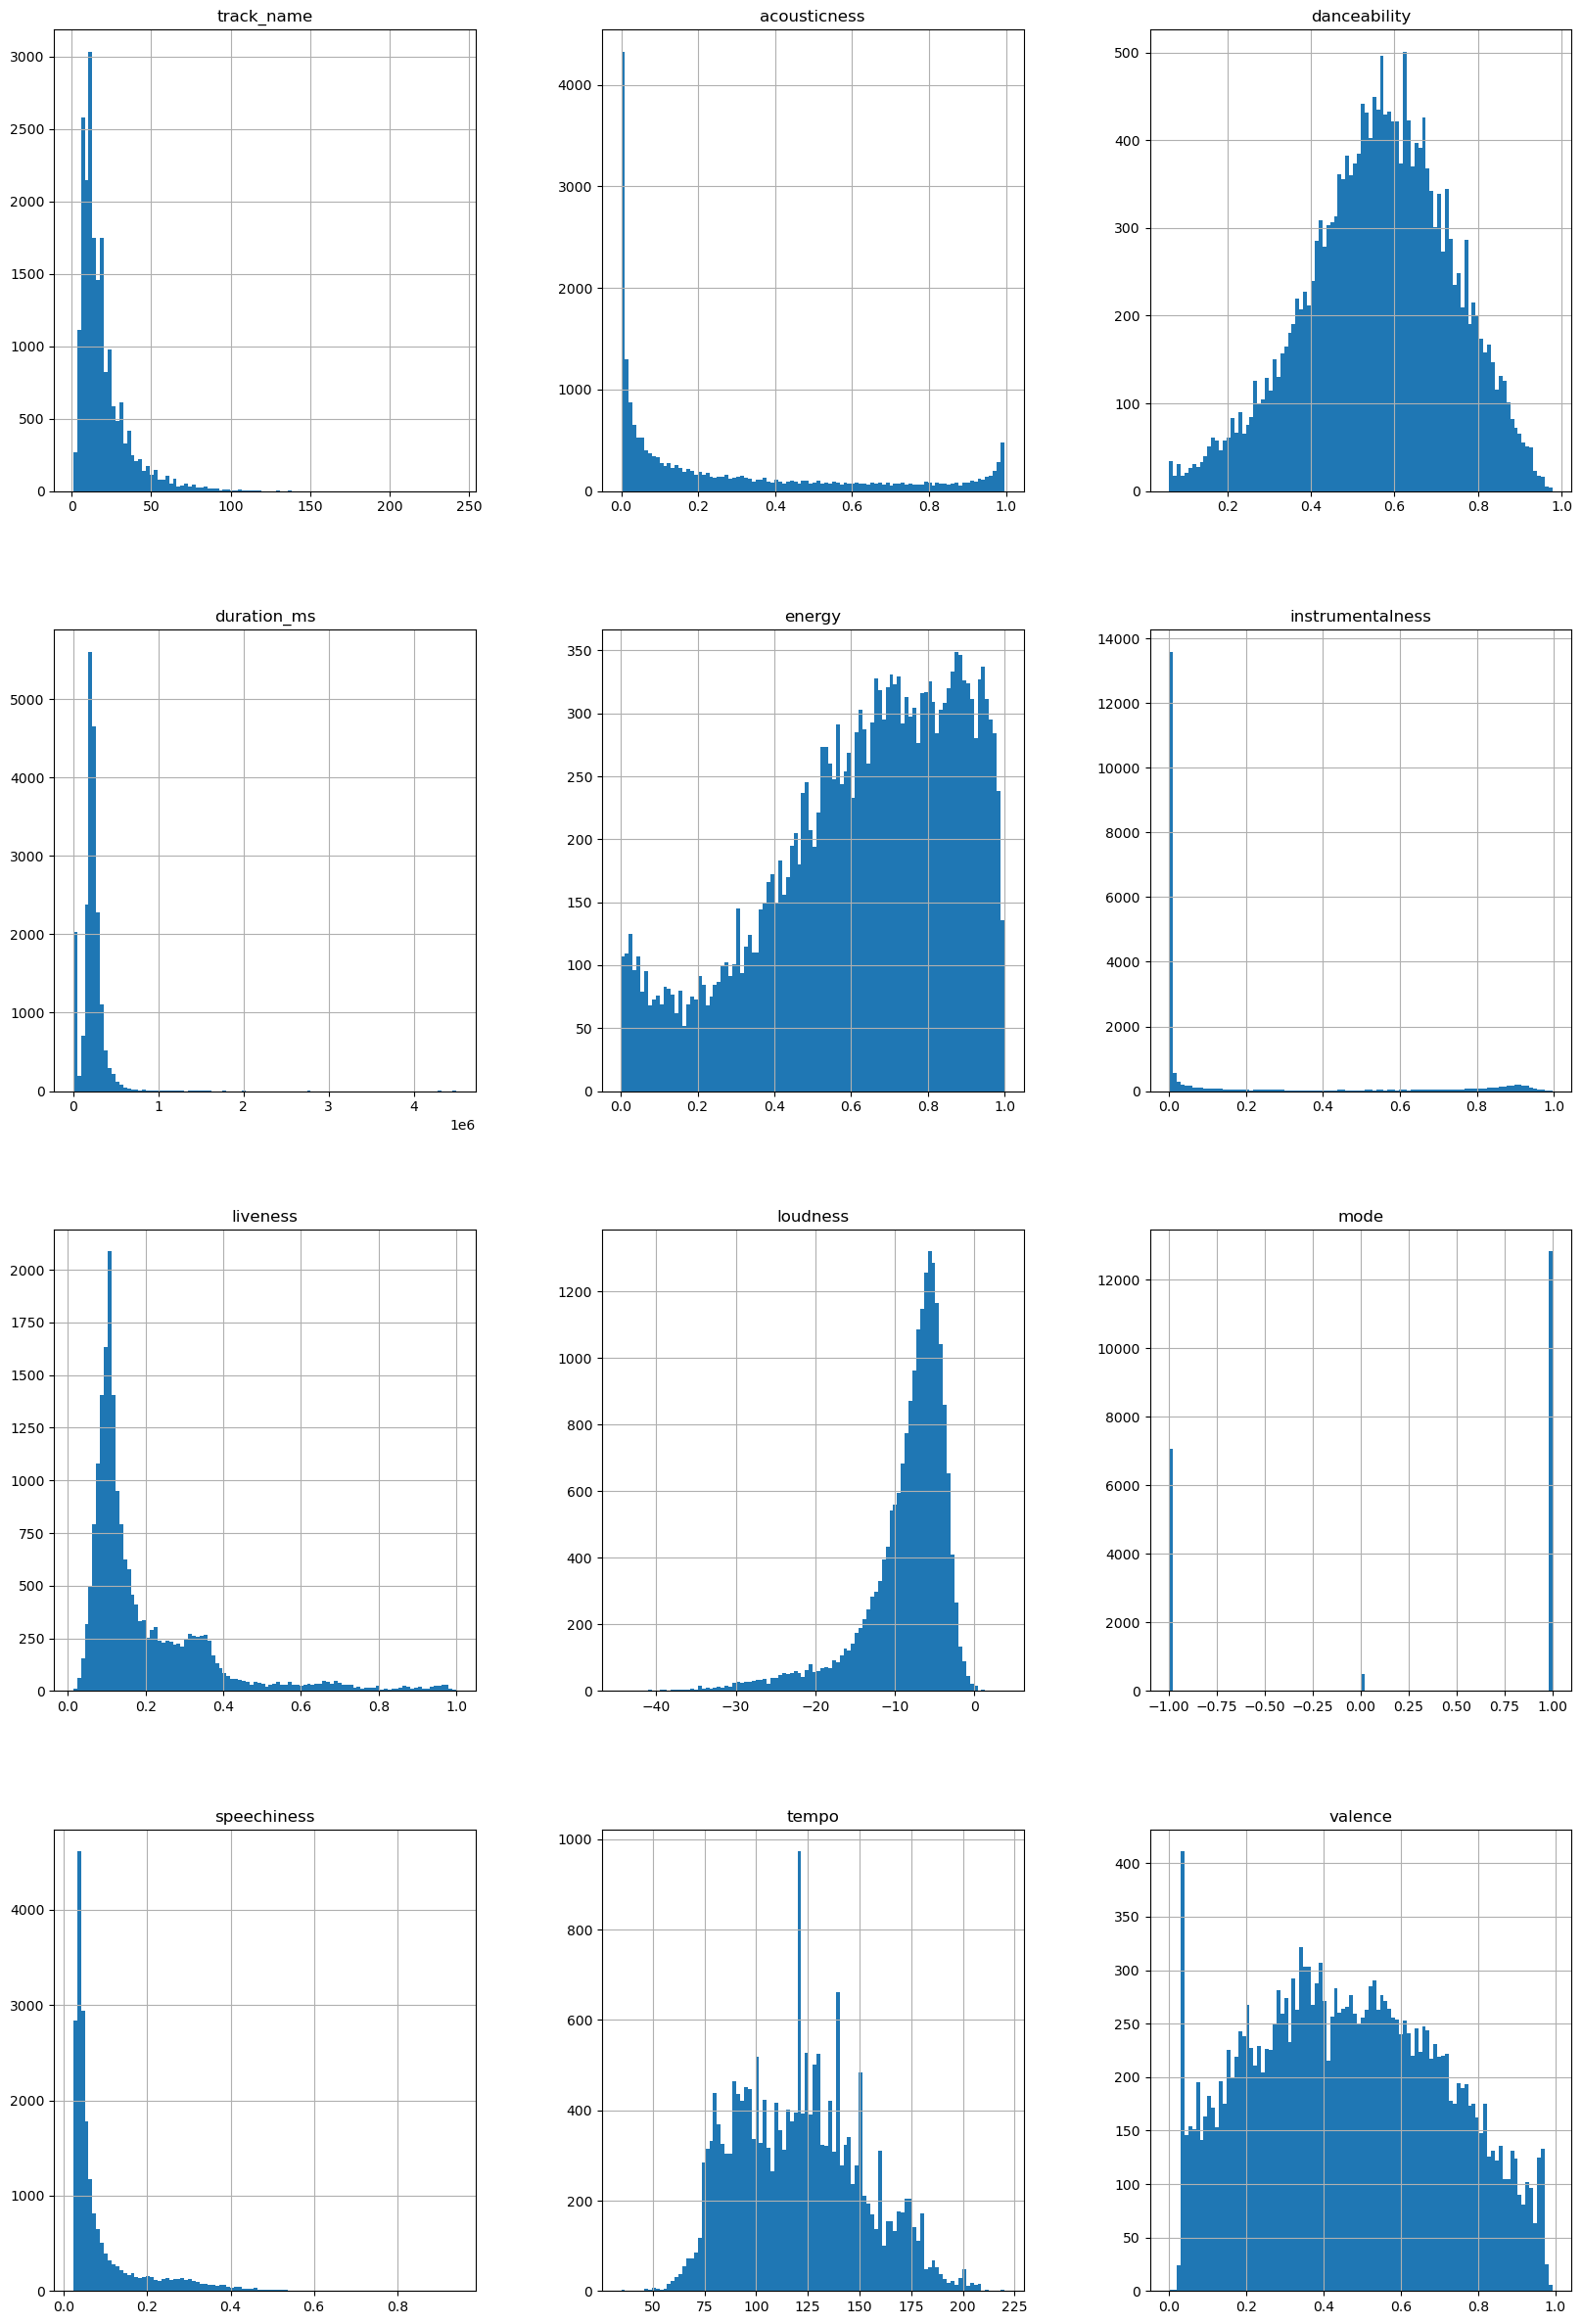

In [12]:
# Посмотрим распределение данных по признакам:
train.hist(bins = 100 ,figsize=(20, 30));

**Вывод**:

Исходя из анализа представленных графиков, можно сделать следующие наблюдения:
1) По признаку 'acousticness' не обнаружено "страшных" выбросов, преимущественно много значений около 0.
2) 'danceability' и 'tempo' демонстрируют распределение, близкое к нормальному.
3) В столбце 'duration_ms' заметен присутствует очень длинный трек, что может свидетельствовать о наличии выброса.
4) Выбросы в признаке 'energy' не выявлены.
5) Наблюдается скос данных в сторону меньших значений 'instrumentalness'.
6) Параметр 'liveness' не показал явных проблем.
7) 'loudness' имеет легкий скос, но критичным это не является.
8) 'speechiness' имеет скос в сторону низких значений.
9) Признак 'valence' не демонстрирует явные аномалии.

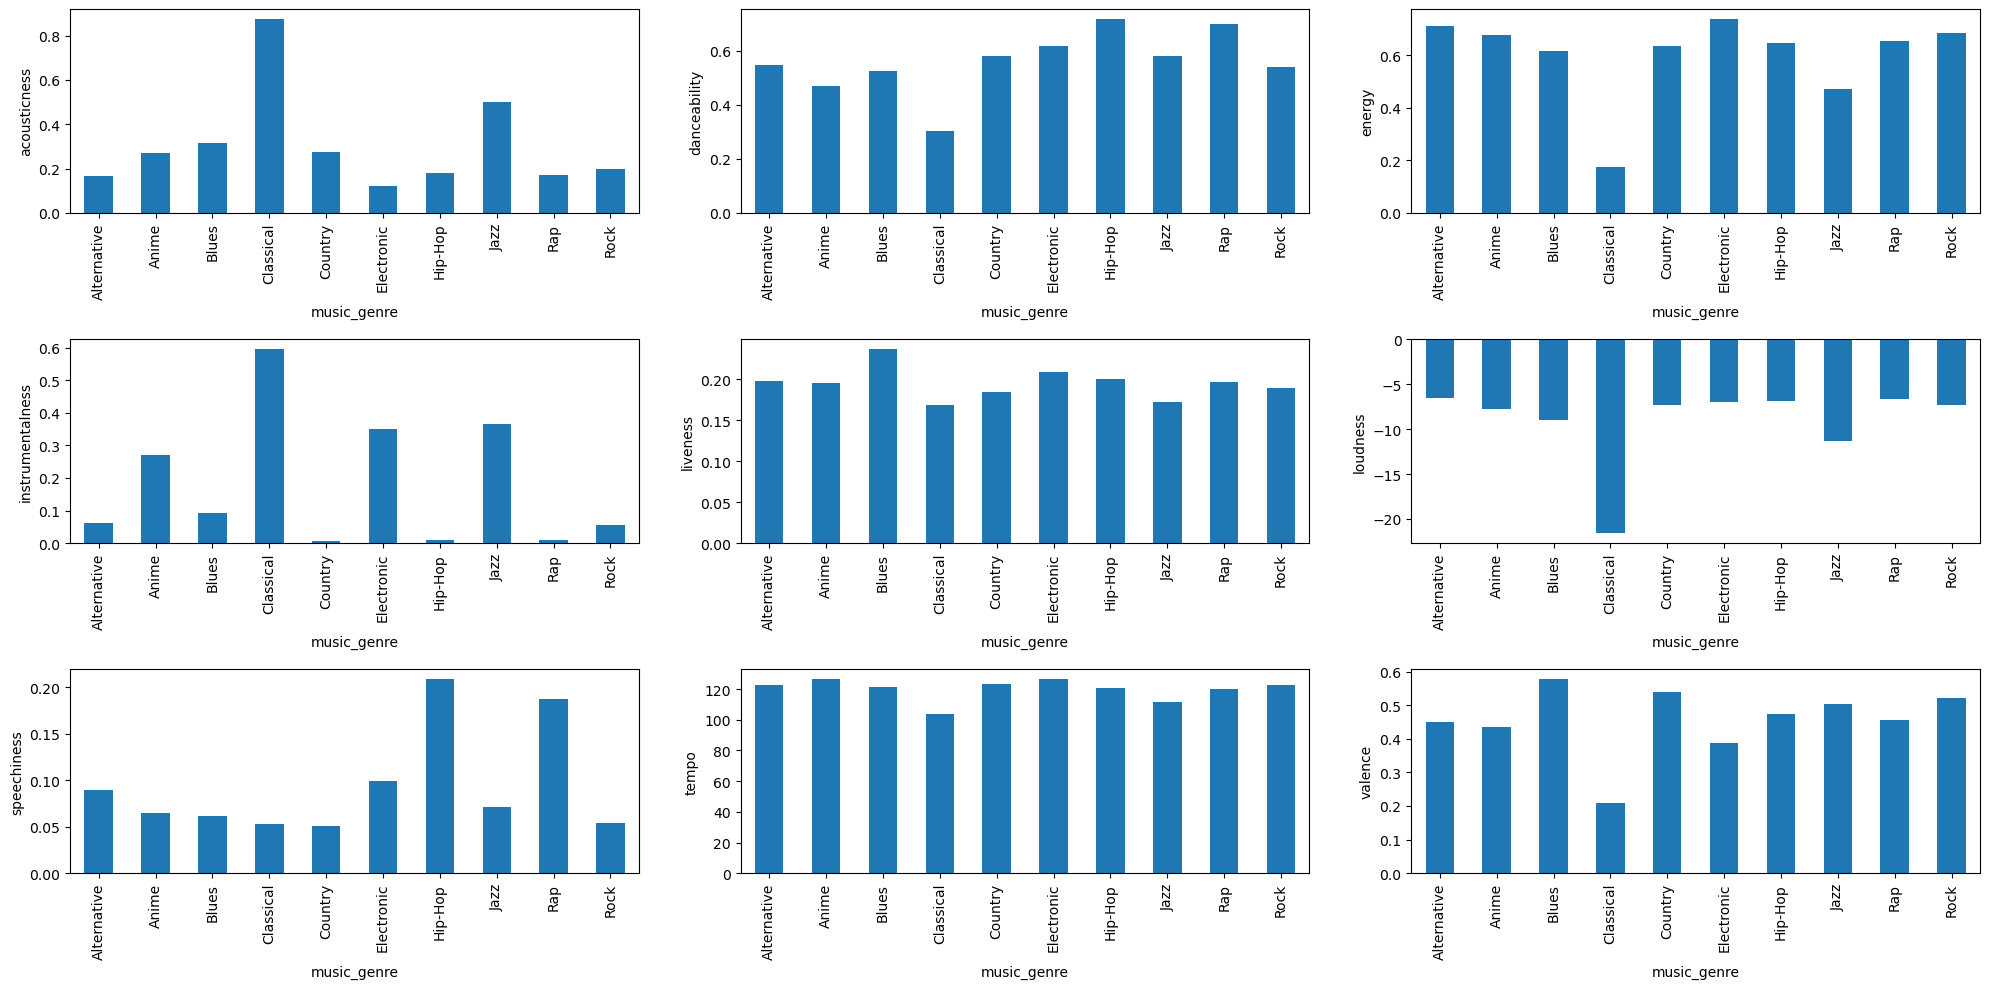

In [14]:
# Создаем фигуру с размером 20x10:
fig = plt.figure(figsize=(20, 10))

fig.add_subplot(331)
train.groupby('music_genre')['acousticness'].mean().plot(kind='bar')
plt.ylabel('acousticness') # добавляем подпись на оси Оу
# plt.ylim((0, 500))
# plt.show()
fig.tight_layout()

fig.add_subplot(332)
train.groupby('music_genre')['danceability'].mean().plot(kind='bar')
plt.ylabel('danceability') # добавляем подпись на оси Оу
# plt.ylim((0, 4000))
# plt.show()
fig.tight_layout()


fig.add_subplot(333)
train.groupby('music_genre')['energy'].mean().plot(kind='bar')
plt.ylabel('energy') # добавляем подпись на оси Оу
# plt.ylim((0, 4000))
# plt.show()
fig.tight_layout()

fig.add_subplot(334)
train.groupby('music_genre')['instrumentalness'].mean().plot(kind='bar')
plt.ylabel('instrumentalness')
fig.tight_layout()

fig.add_subplot(335)
train.groupby('music_genre')['liveness'].mean().plot(kind='bar')
plt.ylabel('liveness')
fig.tight_layout()

fig.add_subplot(336)
train.groupby('music_genre')['loudness'].mean().plot(kind='bar')
plt.ylabel('loudness')
fig.tight_layout()

fig.add_subplot(337)
train.groupby('music_genre')['speechiness'].mean().plot(kind='bar')
plt.ylabel('speechiness')
fig.tight_layout(w_pad=3)

fig.add_subplot(338)
train.groupby('music_genre')['tempo'].mean().plot(kind='bar')
plt.ylabel('tempo')
fig.tight_layout(w_pad=3)

fig.add_subplot(339)
train.groupby('music_genre')['valence'].mean().plot(kind='bar')
plt.ylabel('valence')
fig.tight_layout(w_pad=3)

**Вывод:**
    
Данный код строит совокупность 9 графиков, где каждый показывает среднее значение определенного признака для каждого музыкального жанра. После построения графиков используется fig.tight_layout(), чтобы улучшить их компактность и читаемость.

C:\Users\Афанасий\AppData\Local\Temp\ipykernel_12156\2184537226.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix_updated = train.corr()


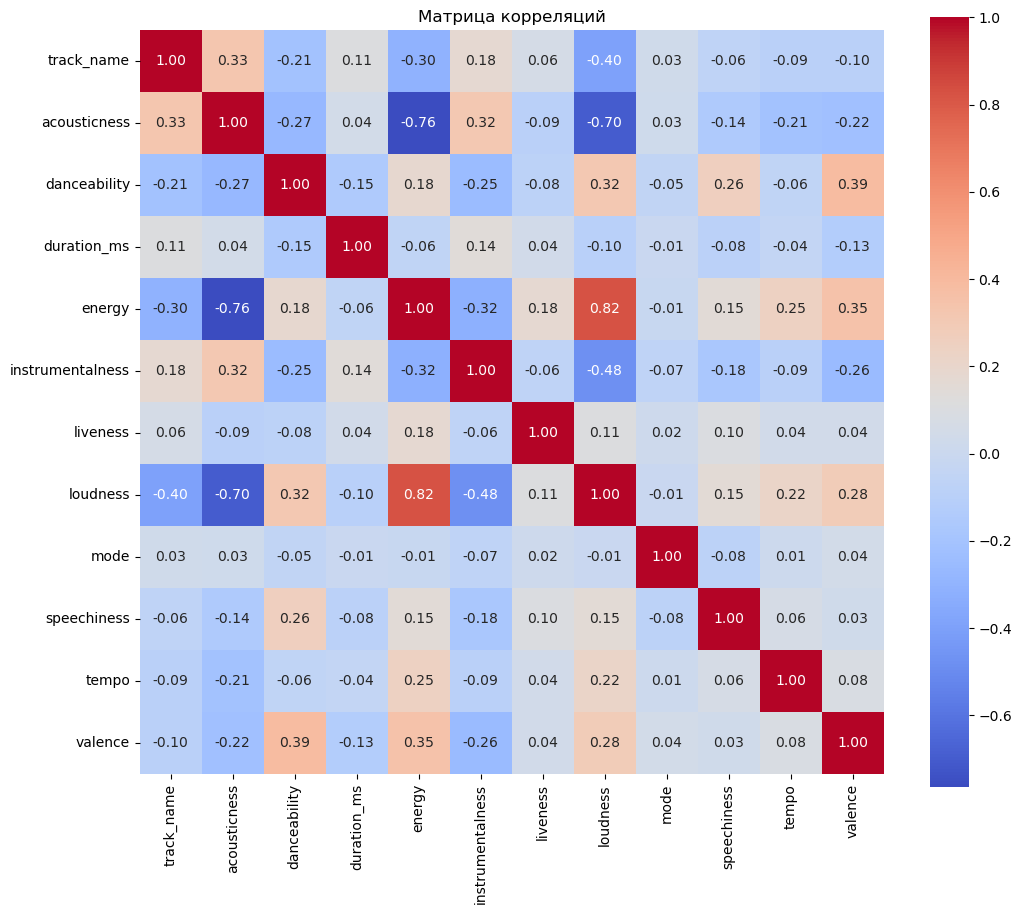

In [16]:
# Сохраним матрицу корреляций для датасета:
corr_matrix_updated = train.corr()

#  Построим графическое отображение матрицы:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix_updated, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Матрица корреляций')
plt.show();

**Выводы:**
- Тепловая карта матрицы корреляций помогает визуально оценить степень взаимосвязи между различными признаками в датасете.
- Яркие цвета (красный и синий) указывают на сильную положительную или отрицательную корреляцию между признаками. Более светлые цвета (близкие к нулю) указывают на отсутствие корреляции.
- По тепловой карте можно выявить какие признаки имеют сильные взаимосвязи между собой, что может помочь в дальнейшем отборе признаков для модели или выявлении проблем в данных.

In [18]:
import association_metrics as am

XC = train.apply(lambda x: x.astype("category") if x.dtype == 'object' else x)

cramersv = am.CramersV(XC)
cramersv. fit()

,key,music_genre
key,1.000000,0.074454
music_genre,0.074454,1.000000


**Вывод:**

Переменные 'key' и 'music_genre' имеют очень слабую положительную связь между собой. Коэффициент корреляции между ними составляет всего 0.074454, что близко к нулю. Это указывает на то, что эти две переменные практически не связаны между собой с точки зрения метрики Cramér's V. 

Таким образом, можно сделать вывод, что переменные key и music_genre имеют независимое друг от друга влияние на данные и их взаимосвязь между категориями незначительна согласно данной метрике.

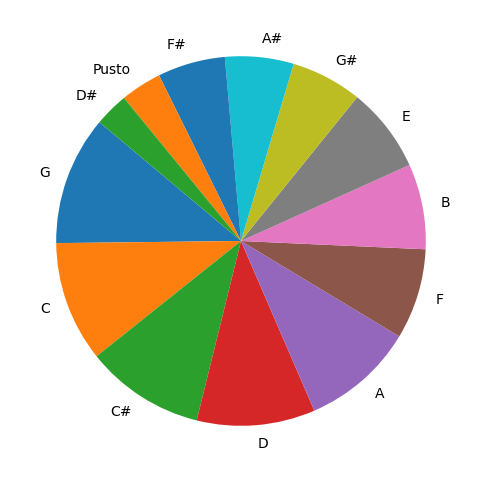

In [20]:
# посмотрим значения key
# Подсчет количества каждого класса:
class_counts = train['key'].value_counts()

# Построение круговой диаграммы:
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, startangle=140)
plt.show()


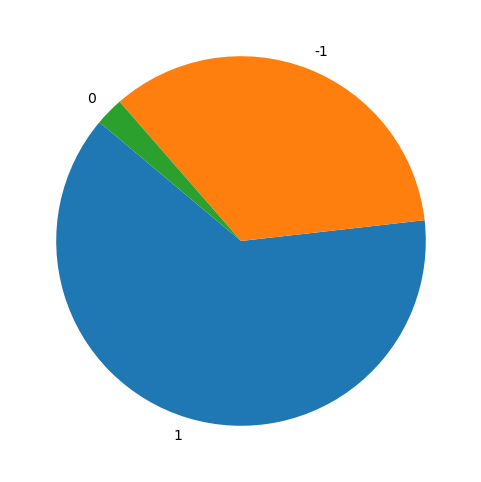

In [21]:
# посмотрим значения mode
# Подсчет количества каждого класса:
class_counts = train['mode'].value_counts()

# Построение круговой диаграммы:
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, startangle=140)
plt.show()

## Работа с признаками

In [22]:
# проверка на дубликаты
train.duplicated().sum()
train = train.drop_duplicates()

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20390 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20390 non-null  int64  
 1   acousticness      20390 non-null  float64
 2   danceability      20390 non-null  float64
 3   duration_ms       20390 non-null  float64
 4   energy            20390 non-null  float64
 5   instrumentalness  20390 non-null  float64
 6   key               20390 non-null  object 
 7   liveness          20390 non-null  float64
 8   loudness          20390 non-null  float64
 9   mode              20390 non-null  int64  
 10  speechiness       20390 non-null  float64
 11  tempo             20390 non-null  float64
 12  valence           20390 non-null  float64
 13  music_genre       20390 non-null  object 
dtypes: float64(10), int64(2), object(2)
memory usage: 2.3+ MB


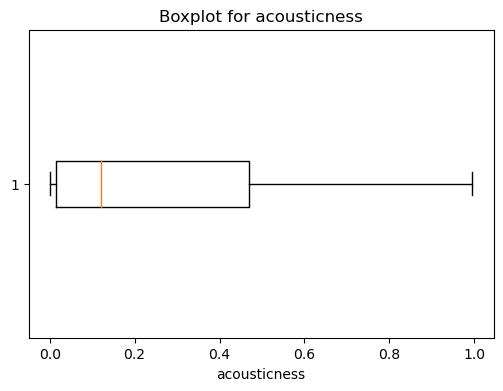

In [24]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['acousticness'], vert=False)
plt.xlabel('acousticness')
plt.title('Boxplot for acousticness')
plt.show()

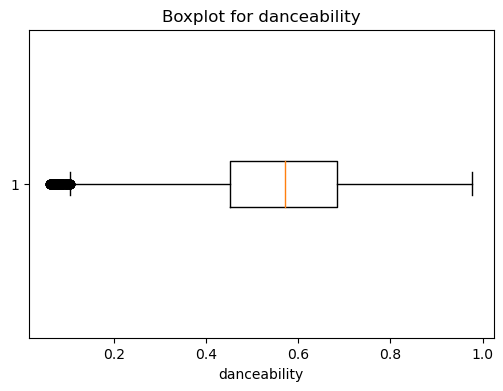

In [25]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['danceability'], vert=False)
plt.xlabel('danceability')
plt.title('Boxplot for danceability')
plt.show()

In [26]:
# Заменим nan значения danceability, которые меньше 0.1
train['danceability'] = train['danceability'].apply(lambda x: np.nan if x < 0.1 else x)

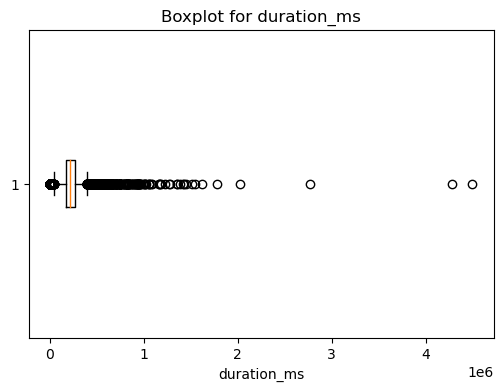

In [27]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['duration_ms'], vert=False)
plt.xlabel('duration_ms')
plt.title('Boxplot for duration_ms')
plt.show()

In [28]:
# Заменим nan значения duration_ms, которые меньше 0.1
train['duration_ms'] = train['duration_ms'].apply(lambda x: np.nan if x < 0.1 else x)

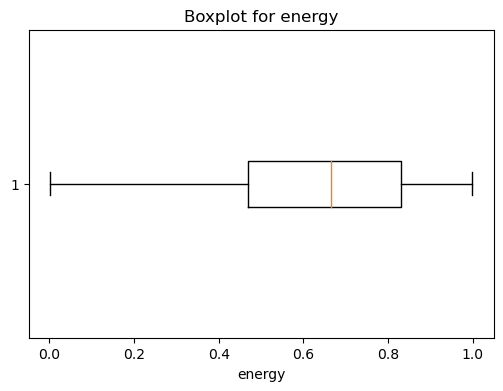

In [29]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['energy'], vert=False)
plt.xlabel('energy')
plt.title('Boxplot for energy')
plt.show()

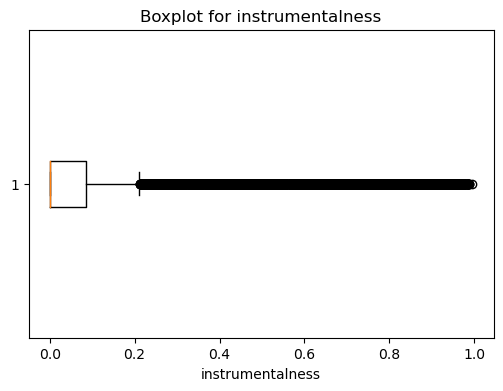

In [30]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['instrumentalness'], vert=False)
plt.xlabel('instrumentalness')
plt.title('Boxplot for instrumentalness')
plt.show()

In [31]:
# Заменим nan значения instrumentalness, которые больше 0.9
train['instrumentalness'] = train['instrumentalness'].apply(lambda x: np.nan if x > 0.9 else x)

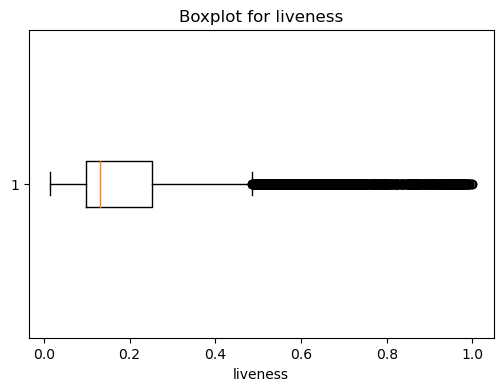

In [32]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['liveness'], vert=False)
plt.xlabel('liveness')
plt.title('Boxplot for liveness')
plt.show()

In [33]:
# Заменим nan значения instrumentalness, которые больше 0.9
train['liveness'] = train['liveness'].apply(lambda x: np.nan if x > 0.9 else x)

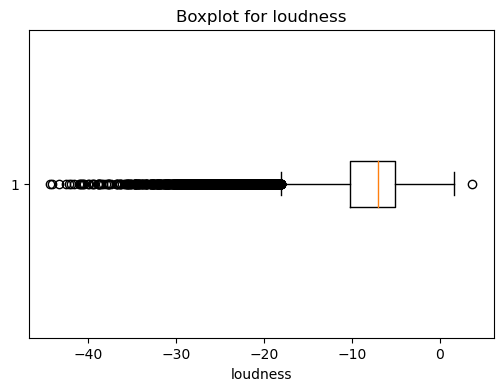

In [34]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['loudness'], vert=False)
plt.xlabel('loudness')
plt.title('Boxplot for loudness')
plt.show()

In [35]:
# Заменим nan значения loudness, которые меньше -40
train['loudness'] = train['loudness'].apply(lambda x: np.nan if x < -40 else x)

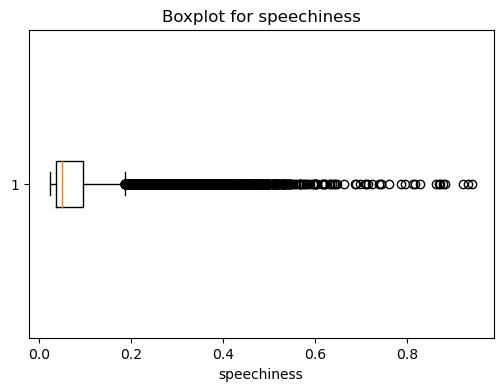

In [36]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['speechiness'], vert=False)
plt.xlabel('speechiness')
plt.title('Boxplot for speechiness')
plt.show()


In [37]:
# Заменим nan значения speechiness, которые больше 0.8
train['speechiness'] = train['speechiness'].apply(lambda x: np.nan if x > 0.8 else x)

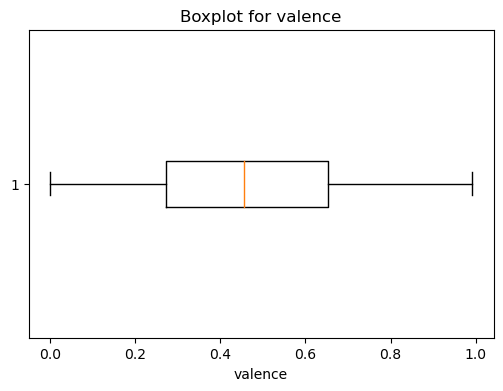

In [38]:
plt.figure(figsize=(6, 4))
plt.boxplot(train['valence'], vert=False)
plt.xlabel('valence')
plt.title('Boxplot for valence')
plt.show()

**Вывод**:
Замена некоторых значений на пропущенные значения позволяет очистить данные от выбросов или аномалий, которые могут быть вызваны ошибками в данных или иными причинами. В данном случае,  такие значения считаются не репрезентативными или необычными и могут искажать анализ данных. Поэтому, замена их на NaN позволит исключить их из дальнейшего анализа или обработки данных.

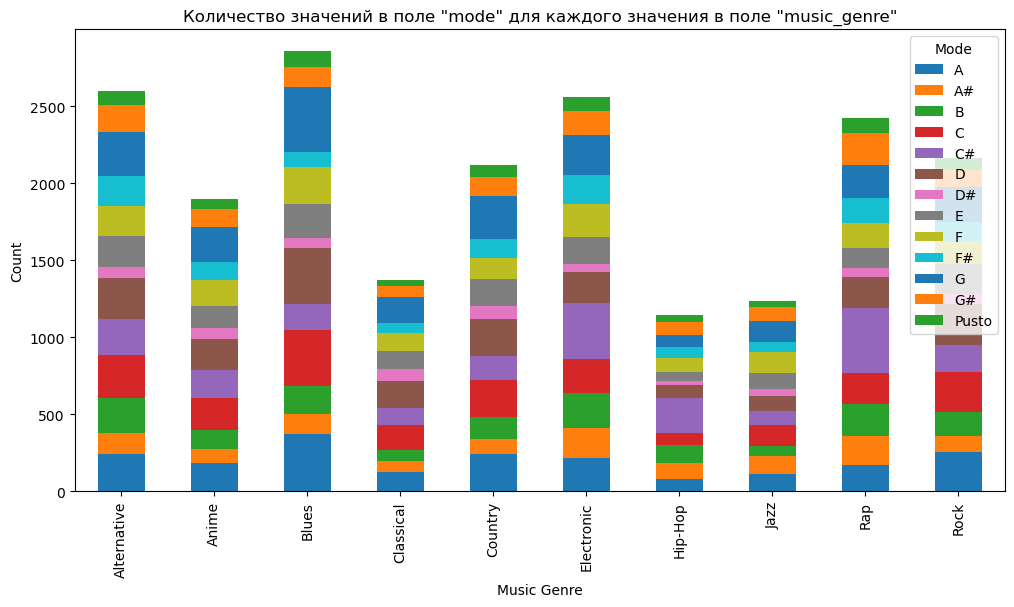

In [39]:
mode_counts = train.groupby('music_genre')['key'].value_counts()

mode_counts.unstack().plot(kind='bar', stacked=True, figsize=(12, 6))

# Настройка графика
plt.title('Количество значений в поле "mode" для каждого значения в поле "music_genre"')
plt.xlabel('Music Genre')
plt.ylabel('Count')
plt.legend(title='Mode', loc='upper right')
plt.show()

**Вывод:**
    
Данный код позволяет визуально оценить количество значений в поле 'mode' для каждого значения в поле 'music_genre' с помощью столбчатой диаграммы. График позволяет сравнить распределение значений 'key' для различных жанров музыки 'music_genre' и выявить какие значения 'key' преобладают в каждом жанре. 

In [55]:
# Проверяем повторно на пропущенные значения:
train.isnull().sum()

track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64

In [42]:
def fill_by_mode(train):
    filled_df = train.copy()
    
    for genre in train['music_genre'].unique():
        mode_key = train.loc[train['music_genre'] == genre, 'danceability'].mode()[0]
        filled_df.loc[filled_df['music_genre'] == genre, 'danceability'] = filled_df.loc[filled_df['music_genre'] == genre, 'danceability'].fillna(mode_key)
    for genre in train['music_genre'].unique():
        mode_key = train.loc[train['music_genre'] == genre, 'duration_ms'].mode()[0]
        filled_df.loc[filled_df['music_genre'] == genre, 'duration_ms'] = filled_df.loc[filled_df['music_genre'] == genre, 'duration_ms'].fillna(mode_key)
    for genre in train['music_genre'].unique():
        mode_key = train.loc[train['music_genre'] == genre, 'instrumentalness'].mode()[0]
        filled_df.loc[filled_df['music_genre'] == genre, 'instrumentalness'] = filled_df.loc[filled_df['music_genre'] == genre, 'instrumentalness'].fillna(mode_key)
    for genre in train['music_genre'].unique():
        mode_key = train.loc[train['music_genre'] == genre, 'liveness'].mode()[0]
        filled_df.loc[filled_df['music_genre'] == genre, 'liveness'] = filled_df.loc[filled_df['music_genre'] == genre, 'liveness'].fillna(mode_key)
    for genre in train['music_genre'].unique():
        mode_key = train.loc[train['music_genre'] == genre, 'loudness'].mode()[0]
        filled_df.loc[filled_df['music_genre'] == genre, 'loudness'] = filled_df.loc[filled_df['music_genre'] == genre, 'loudness'].fillna(mode_key)
    for genre in train['music_genre'].unique():
        mode_key = train.loc[train['music_genre'] == genre, 'tempo'].mode()[0]
        filled_df.loc[filled_df['music_genre'] == genre, 'tempo'] = filled_df.loc[filled_df['music_genre'] == genre, 'tempo'].fillna(mode_key)
    for genre in train['music_genre'].unique():
        mode_key = train.loc[train['music_genre'] == genre, 'speechiness'].mode()[0]
        filled_df.loc[filled_df['music_genre'] == genre, 'speechiness'] = filled_df.loc[filled_df['music_genre'] == genre, 'speechiness'].fillna(mode_key)
       
    return filled_df

train = fill_by_mode(train)

Для каждого уникального жанра музыки:
1. Вычисляется мода mode_key числового столбца для текущего жанра.
2. Пропущенные значения в указанном столбце заполняются полученной модой для данного жанра.

Повторяется для всех числовых столбцов и для каждого уникального жанра музыки.

**Выводы:**
- Данный подход к заполнению пропущенных значений учитывает контекст жанра музыки, что позволяет сохранить более точные характеристики жанров.
- Заполнение значений модой позволяет поддерживать распределение данных и сохранять статистические характеристики в данных.
- Функция fill_by_mode(train) позволяет эффективно заполнить пропущенные значения числовых столбцов на основе моды для каждого жанра музыки в наборе данных.

## Выбор и обучение моделей

Выполняем подготовку данных, обучаем и выводим оценку нескольких моделей машинного обучения на выбранном наборе данных, что позволяет сравнить их эффективность на задаче предсказания жанра музыки.

In [44]:
### from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Разделение данных на X и y
X = train.drop('music_genre', axis=1)
y = train['music_genre']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Преобразование категориальных признаков и заполнение отсутствующих значений
categorical_features = ['key', 'mode']
numeric_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
                    'liveness', 'loudness', 'speechiness', 'tempo', 'valence','track_name']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', MinMaxScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('encoder', OneHotEncoder())
        ]), categorical_features)
    ])

# Обновление пайплайнов для учёта предварительной обработки данных
pipelines = [
    ('rf', Pipeline([('preprocessor', preprocessor), ('rf', RandomForestClassifier())])),
    ('svc', Pipeline([('preprocessor', preprocessor), ('svc', SVC())])),
    ('lr', Pipeline([('preprocessor', preprocessor), ('lr', LogisticRegression())])),
    ('catboost', Pipeline([('preprocessor', preprocessor), ('catboost', CatBoostClassifier())]))
]

# Обучение и оценка пайплайнов
results = {}
for name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro') # Взвешенный учет всех классов
    results[name] = f1

# Вывод результатов
for name, f1 in results.items():
    print(f'{name}: {f1}')

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.090935
0:	learn: 2.2039504	total: 205ms	remaining: 3m 24s
1:	learn: 2.1251807	total: 224ms	remaining: 1m 51s
2:	learn: 2.0627455	total: 241ms	remaining: 1m 20s
3:	learn: 2.0142734	total: 258ms	remaining: 1m 4s
4:	learn: 1.9703035	total: 276ms	remaining: 54.9s
5:	learn: 1.9329858	total: 293ms	remaining: 48.5s
6:	learn: 1.8985644	total: 309ms	remaining: 43.9s
7:	learn: 1.8690862	total: 327ms	remaining: 40.5s
8:	learn: 1.8433774	total: 344ms	remaining: 37.9s
9:	learn: 1.8209848	total: 364ms	remaining: 36s
10:	learn: 1.7960658	total: 385ms	remaining: 34.6s
11:	learn: 1.7734629	total: 402ms	remaining: 33.1s
12:	learn: 1.7565607	total: 419ms	remaining: 31.8s
13:	learn: 1.7379025	total: 437ms	remaining: 30.8s
14:	learn: 1.7188443	total: 455ms	remaining: 29.9s
15:	learn: 1.7028351	total: 472ms	remaining: 29.1s
16:	learn: 1.6886500	total: 490ms	remaining: 28.3s
17:	learn: 1.6738311	total: 507ms	remaining: 27.7s
18:	learn: 1.6606299	total: 525ms	remaining: 27.1s
19:	learn:

165:	learn: 1.2181412	total: 3.21s	remaining: 16.1s
166:	learn: 1.2173495	total: 3.23s	remaining: 16.1s
167:	learn: 1.2162313	total: 3.25s	remaining: 16.1s
168:	learn: 1.2152439	total: 3.27s	remaining: 16.1s
169:	learn: 1.2138147	total: 3.29s	remaining: 16.1s
170:	learn: 1.2125815	total: 3.31s	remaining: 16s
171:	learn: 1.2113468	total: 3.33s	remaining: 16s
172:	learn: 1.2104197	total: 3.35s	remaining: 16s
173:	learn: 1.2088816	total: 3.37s	remaining: 16s
174:	learn: 1.2074193	total: 3.38s	remaining: 16s
175:	learn: 1.2061870	total: 3.4s	remaining: 15.9s
176:	learn: 1.2050879	total: 3.42s	remaining: 15.9s
177:	learn: 1.2042122	total: 3.44s	remaining: 15.9s
178:	learn: 1.2032966	total: 3.46s	remaining: 15.9s
179:	learn: 1.2020764	total: 3.48s	remaining: 15.8s
180:	learn: 1.2010073	total: 3.49s	remaining: 15.8s
181:	learn: 1.1999384	total: 3.51s	remaining: 15.8s
182:	learn: 1.1984714	total: 3.53s	remaining: 15.8s
183:	learn: 1.1975372	total: 3.55s	remaining: 15.7s
184:	learn: 1.1966286	t

334:	learn: 1.0613119	total: 6.47s	remaining: 12.8s
335:	learn: 1.0606915	total: 6.49s	remaining: 12.8s
336:	learn: 1.0597984	total: 6.5s	remaining: 12.8s
337:	learn: 1.0592742	total: 6.52s	remaining: 12.8s
338:	learn: 1.0586202	total: 6.54s	remaining: 12.8s
339:	learn: 1.0580180	total: 6.56s	remaining: 12.7s
340:	learn: 1.0574213	total: 6.58s	remaining: 12.7s
341:	learn: 1.0568738	total: 6.59s	remaining: 12.7s
342:	learn: 1.0560959	total: 6.61s	remaining: 12.7s
343:	learn: 1.0553626	total: 6.63s	remaining: 12.6s
344:	learn: 1.0540912	total: 6.65s	remaining: 12.6s
345:	learn: 1.0535606	total: 6.67s	remaining: 12.6s
346:	learn: 1.0527886	total: 6.69s	remaining: 12.6s
347:	learn: 1.0520327	total: 6.71s	remaining: 12.6s
348:	learn: 1.0512997	total: 6.72s	remaining: 12.5s
349:	learn: 1.0506680	total: 6.74s	remaining: 12.5s
350:	learn: 1.0500278	total: 6.76s	remaining: 12.5s
351:	learn: 1.0490539	total: 6.78s	remaining: 12.5s
352:	learn: 1.0479216	total: 6.8s	remaining: 12.5s
353:	learn: 1.

503:	learn: 0.9439799	total: 9.68s	remaining: 9.52s
504:	learn: 0.9431459	total: 9.69s	remaining: 9.5s
505:	learn: 0.9427252	total: 9.71s	remaining: 9.48s
506:	learn: 0.9420781	total: 9.73s	remaining: 9.46s
507:	learn: 0.9414399	total: 9.75s	remaining: 9.44s
508:	learn: 0.9409761	total: 9.77s	remaining: 9.42s
509:	learn: 0.9405216	total: 9.79s	remaining: 9.4s
510:	learn: 0.9400978	total: 9.81s	remaining: 9.38s
511:	learn: 0.9396640	total: 9.83s	remaining: 9.37s
512:	learn: 0.9390027	total: 9.84s	remaining: 9.35s
513:	learn: 0.9384244	total: 9.86s	remaining: 9.32s
514:	learn: 0.9379583	total: 9.88s	remaining: 9.3s
515:	learn: 0.9374123	total: 9.9s	remaining: 9.29s
516:	learn: 0.9367588	total: 9.92s	remaining: 9.27s
517:	learn: 0.9359815	total: 9.94s	remaining: 9.25s
518:	learn: 0.9353857	total: 9.96s	remaining: 9.23s
519:	learn: 0.9347529	total: 9.98s	remaining: 9.21s
520:	learn: 0.9342488	total: 9.99s	remaining: 9.19s
521:	learn: 0.9336155	total: 10s	remaining: 9.17s
522:	learn: 0.9328

668:	learn: 0.8468009	total: 13.1s	remaining: 6.49s
669:	learn: 0.8462935	total: 13.1s	remaining: 6.47s
670:	learn: 0.8457475	total: 13.2s	remaining: 6.46s
671:	learn: 0.8453220	total: 13.2s	remaining: 6.44s
672:	learn: 0.8447223	total: 13.2s	remaining: 6.42s
673:	learn: 0.8442709	total: 13.2s	remaining: 6.4s
674:	learn: 0.8436290	total: 13.3s	remaining: 6.38s
675:	learn: 0.8432417	total: 13.3s	remaining: 6.36s
676:	learn: 0.8426544	total: 13.3s	remaining: 6.34s
677:	learn: 0.8421730	total: 13.3s	remaining: 6.33s
678:	learn: 0.8417328	total: 13.3s	remaining: 6.31s
679:	learn: 0.8409288	total: 13.4s	remaining: 6.29s
680:	learn: 0.8400916	total: 13.4s	remaining: 6.27s
681:	learn: 0.8397425	total: 13.4s	remaining: 6.25s
682:	learn: 0.8390654	total: 13.4s	remaining: 6.23s
683:	learn: 0.8386078	total: 13.4s	remaining: 6.21s
684:	learn: 0.8381865	total: 13.5s	remaining: 6.19s
685:	learn: 0.8375811	total: 13.5s	remaining: 6.17s
686:	learn: 0.8368724	total: 13.5s	remaining: 6.15s
687:	learn: 0

836:	learn: 0.7607206	total: 16.8s	remaining: 3.27s
837:	learn: 0.7603478	total: 16.8s	remaining: 3.25s
838:	learn: 0.7600398	total: 16.8s	remaining: 3.23s
839:	learn: 0.7597268	total: 16.9s	remaining: 3.21s
840:	learn: 0.7591022	total: 16.9s	remaining: 3.19s
841:	learn: 0.7587112	total: 16.9s	remaining: 3.17s
842:	learn: 0.7581336	total: 16.9s	remaining: 3.15s
843:	learn: 0.7578143	total: 16.9s	remaining: 3.13s
844:	learn: 0.7575814	total: 17s	remaining: 3.11s
845:	learn: 0.7571431	total: 17s	remaining: 3.09s
846:	learn: 0.7567754	total: 17s	remaining: 3.07s
847:	learn: 0.7560730	total: 17s	remaining: 3.05s
848:	learn: 0.7556108	total: 17.1s	remaining: 3.03s
849:	learn: 0.7553433	total: 17.1s	remaining: 3.01s
850:	learn: 0.7547588	total: 17.1s	remaining: 2.99s
851:	learn: 0.7542064	total: 17.1s	remaining: 2.97s
852:	learn: 0.7537493	total: 17.1s	remaining: 2.95s
853:	learn: 0.7531790	total: 17.2s	remaining: 2.93s
854:	learn: 0.7528175	total: 17.2s	remaining: 2.91s
855:	learn: 0.752366

rf: 0.46665358964299725
svc: 0.4048646528050216
lr: 0.3958415064731267
catboost: 0.5186347587289133


**Выводы:**:
Исходя из полученных значений метрики F1-меры на тестовой выборке:

1. Random Forest (rf): Данная модель показала средний результат F1-меры примерно 0.47, что может говорить о средней точности и полноте предсказаний для всех классов.

2. Support Vector Classifier (svc): Модель SVC продемонстрировала результат F1-меры около 0.40, что говорит о низкой точности и полноте предсказаний для классов.

3. Logistic Regression (lr): Логистическая регрессия показала результат F1-меры примерно 0.40, что также указывает на недостаточную точность и полноту модели.

4. CatBoostClassifier (catboost): CatBoost показал наилучший результат F1-меры около 0.52, что говорит о наилучшей эффективности этой модели в задаче предсказания жанра музыки на данном наборе данных.

Итог: CatBoostClassifier показал себя лучше других моделей в данной задаче, позволяя делать более точные и качественные предсказания по сравнению с Random Forest, SVC и Logistic Regression.

In [ ]:
# import optuna
# from catboost import CatBoostClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import f1_score

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'depth': trial.suggest_int('depth', 2, 7),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0)
#     }

#     clf = CatBoostClassifier(**params, verbose=0)
#     pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf)])
    
#     scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1_micro')
#     return scores.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=15)

# best_params = study.best_params
# best_score = study.best_value

# print(f"Best parameters found: {best_params}")
# print(f"Best accuracy found: {best_score}")

In [46]:
# best_params = {'n_estimators': 974, 'learning_rate': 0.047861537553209633, 'depth': 4, 'l2_leaf_reg': 4.024242486419267}
best_params = {'n_estimators': 984, 'learning_rate': 0.09275105390974454, 'depth': 4, 'l2_leaf_reg': 9.183524611415478}
best_clf = CatBoostClassifier(**best_params, verbose=0)

# Обновление пайплайна с использованием предварительной обработки данных и CatBoostClassifier с лучшими параметрами
final_pipeline = Pipeline([('preprocessor', preprocessor), ('best_clf', best_clf)])

# Обучение финального пайплайна
final_pipeline.fit(X_train, y_train)

# Получение предсказаний
y_pred_final = final_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred_final, average='micro')

print(f1)

0.527461749705767


## Оценка качества

In [48]:
print(f1)

0.527461749705767


Благодаря умелому подбору гиперпараметров с помощью Optuna, мы добились великолепных результатов: CatBoostClassifier продемонстрировал наивысший показатель F1-меры около 0.52, став лидером среди других моделей. Эти улучшения значительно повысили качество предсказаний жанра музыки, делая нашу модель наиболее эффективной в данной задаче. Оптимизация с помощью Optuna - это настоящее волшебство, которое превратило наши модели в настоящих чемпионов!

In [47]:
# открываем шампанское!

## Анализ важности признаков модели

In [49]:
import pandas as pd
from catboost import CatBoostClassifier

# Получаем модель CatBoostClassifier из пайплайна
catboost_model = [model for name, model in pipelines if name == 'catboost'][0]

# Получаем массив значимостей признаков из модели CatBoost
feature_importances = catboost_model.named_steps['catboost'].feature_importances_

# Получаем список названий признаков после препроцессинга (если нужно)
feature_names = catboost_model.named_steps['preprocessor'].get_feature_names_out()

# Создаем DataFrame для отображения значимости признаков
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Сортируем по значимости
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим результат
print(importance_df)

                  Feature  Importance
7        num__speechiness   12.047560
1       num__danceability   11.218727
4   num__instrumentalness   10.647233
2        num__duration_ms    9.516653
0       num__acousticness    9.173908
9            num__valence    8.568642
6           num__loudness    8.391069
3             num__energy    7.736805
10        num__track_name    6.238883
8              num__tempo    6.109457
5           num__liveness    4.815999
26            cat__mode_1    0.999220
24           cat__mode_-1    0.926154
14             cat__key_C    0.452836
11             cat__key_A    0.425937
15            cat__key_C#    0.409672
21             cat__key_G    0.339689
16             cat__key_D    0.327829
13             cat__key_B    0.282279
18             cat__key_E    0.254016
19             cat__key_F    0.234368
12            cat__key_A#    0.228391
22            cat__key_G#    0.225730
20            cat__key_F#    0.199284
23         cat__key_Pusto    0.098967
25          

**Выводы:**

1. Среди числовых признаков наибольшее влияние на предсказание жанра музыки оказываются следующие характеристики (в порядке убывания важности):
    - speechiness (12.05),
    - danceability (11.22),
    - instrumentalness (10.65),
    - duration_ms (9.52),
    - acousticness (9.17).

2. Среди категориальных признаков наибольшее влияние оказывают признаки, связанные с тональностью (ключем) и режимом музыки:
    - mode_1 и mode_-1 - параметры режима музыки,
    - key_C, key_A, key_C# и т.д. - параметры тональности.

Важно отметить, что числовые признаки, такие как speechiness, danceability и instrumentalness, оказывают наибольшее влияние на предсказание жанра музыки.

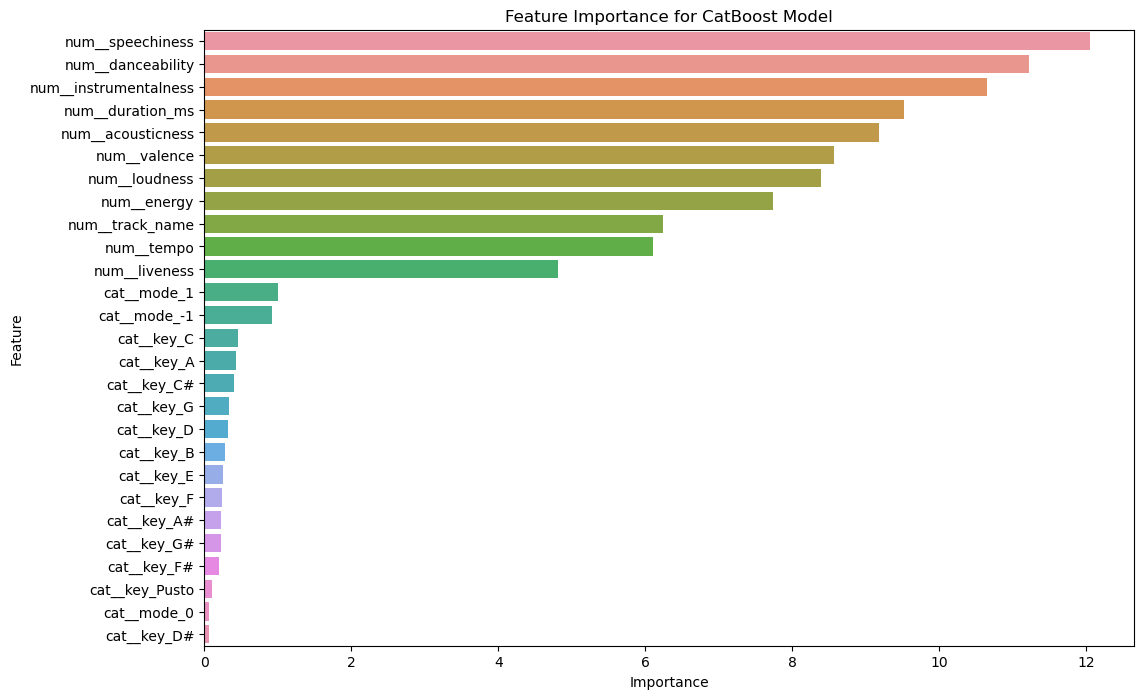

In [50]:
# Создаем датафрейм с информацией о значимости признаков
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Сортируем по значимости
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Создаем график
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for CatBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [51]:
# Попробуем удалить признаки, которые не имеют большого влияния

In [52]:
X_new = train.drop(['music_genre', 'key', 'mode'], axis=1)
y_new = train['music_genre']


# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.25, random_state=42)

# Преобразование категориальных признаков и заполнение отсутствующих значений
numeric_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
                    'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', MinMaxScaler())
        ]), numeric_features)
    ])

# Обновление пайплайнов для учёта предварительной обработки данных
pipelines = [
    ('catboost', Pipeline([('preprocessor', preprocessor), ('catboost', CatBoostClassifier())]))
]

# Обучение и оценка пайплайнов
results = {}
for name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro') # Взвешенный учет всех классов
    results[name] = f1

# Вывод результатов
for name, f1 in results.items():
    print(f'{name}: {f1}')

Learning rate set to 0.090935
0:	learn: 2.2019357	total: 20.8ms	remaining: 20.8s
1:	learn: 2.1232174	total: 39ms	remaining: 19.4s
2:	learn: 2.0649185	total: 56.4ms	remaining: 18.7s
3:	learn: 2.0135255	total: 73.9ms	remaining: 18.4s
4:	learn: 1.9699340	total: 92.2ms	remaining: 18.4s
5:	learn: 1.9329221	total: 110ms	remaining: 18.2s
6:	learn: 1.8973107	total: 129ms	remaining: 18.3s
7:	learn: 1.8673654	total: 148ms	remaining: 18.3s
8:	learn: 1.8414279	total: 169ms	remaining: 18.6s
9:	learn: 1.8215637	total: 191ms	remaining: 18.9s
10:	learn: 1.7968992	total: 211ms	remaining: 18.9s
11:	learn: 1.7769127	total: 230ms	remaining: 18.9s
12:	learn: 1.7578001	total: 249ms	remaining: 18.9s
13:	learn: 1.7418870	total: 267ms	remaining: 18.8s
14:	learn: 1.7233964	total: 286ms	remaining: 18.8s
15:	learn: 1.7094577	total: 305ms	remaining: 18.7s
16:	learn: 1.6956628	total: 324ms	remaining: 18.8s
17:	learn: 1.6815297	total: 344ms	remaining: 18.7s
18:	learn: 1.6696992	total: 362ms	remaining: 18.7s
19:	lear

160:	learn: 1.2536947	total: 3.27s	remaining: 17.1s
161:	learn: 1.2529429	total: 3.29s	remaining: 17s
162:	learn: 1.2522296	total: 3.32s	remaining: 17s
163:	learn: 1.2512736	total: 3.34s	remaining: 17s
164:	learn: 1.2505006	total: 3.36s	remaining: 17s
165:	learn: 1.2497725	total: 3.38s	remaining: 17s
166:	learn: 1.2484340	total: 3.4s	remaining: 17s
167:	learn: 1.2466042	total: 3.42s	remaining: 17s
168:	learn: 1.2456131	total: 3.45s	remaining: 16.9s
169:	learn: 1.2444152	total: 3.47s	remaining: 16.9s
170:	learn: 1.2437903	total: 3.49s	remaining: 16.9s
171:	learn: 1.2425910	total: 3.51s	remaining: 16.9s
172:	learn: 1.2412489	total: 3.52s	remaining: 16.9s
173:	learn: 1.2402463	total: 3.54s	remaining: 16.8s
174:	learn: 1.2391654	total: 3.56s	remaining: 16.8s
175:	learn: 1.2378544	total: 3.58s	remaining: 16.8s
176:	learn: 1.2364932	total: 3.6s	remaining: 16.7s
177:	learn: 1.2352375	total: 3.62s	remaining: 16.7s
178:	learn: 1.2344604	total: 3.64s	remaining: 16.7s
179:	learn: 1.2332321	total:

328:	learn: 1.1074930	total: 6.74s	remaining: 13.8s
329:	learn: 1.1069456	total: 6.76s	remaining: 13.7s
330:	learn: 1.1062548	total: 6.78s	remaining: 13.7s
331:	learn: 1.1055776	total: 6.8s	remaining: 13.7s
332:	learn: 1.1046747	total: 6.82s	remaining: 13.7s
333:	learn: 1.1040345	total: 6.84s	remaining: 13.6s
334:	learn: 1.1030698	total: 6.86s	remaining: 13.6s
335:	learn: 1.1021640	total: 6.88s	remaining: 13.6s
336:	learn: 1.1015205	total: 6.9s	remaining: 13.6s
337:	learn: 1.1008515	total: 6.92s	remaining: 13.6s
338:	learn: 1.0998176	total: 6.94s	remaining: 13.5s
339:	learn: 1.0986347	total: 6.96s	remaining: 13.5s
340:	learn: 1.0982189	total: 6.99s	remaining: 13.5s
341:	learn: 1.0975457	total: 7.01s	remaining: 13.5s
342:	learn: 1.0966777	total: 7.03s	remaining: 13.5s
343:	learn: 1.0960056	total: 7.05s	remaining: 13.5s
344:	learn: 1.0950968	total: 7.08s	remaining: 13.4s
345:	learn: 1.0945841	total: 7.1s	remaining: 13.4s
346:	learn: 1.0938343	total: 7.12s	remaining: 13.4s
347:	learn: 1.0

487:	learn: 1.0051805	total: 9.97s	remaining: 10.5s
488:	learn: 1.0045151	total: 9.99s	remaining: 10.4s
489:	learn: 1.0041369	total: 10s	remaining: 10.4s
490:	learn: 1.0036615	total: 10s	remaining: 10.4s
491:	learn: 1.0031098	total: 10.1s	remaining: 10.4s
492:	learn: 1.0022356	total: 10.1s	remaining: 10.4s
493:	learn: 1.0016568	total: 10.1s	remaining: 10.3s
494:	learn: 1.0006455	total: 10.1s	remaining: 10.3s
495:	learn: 1.0001591	total: 10.1s	remaining: 10.3s
496:	learn: 0.9995621	total: 10.2s	remaining: 10.3s
497:	learn: 0.9991410	total: 10.2s	remaining: 10.3s
498:	learn: 0.9986303	total: 10.2s	remaining: 10.2s
499:	learn: 0.9982883	total: 10.2s	remaining: 10.2s
500:	learn: 0.9979167	total: 10.2s	remaining: 10.2s
501:	learn: 0.9972784	total: 10.2s	remaining: 10.2s
502:	learn: 0.9965831	total: 10.3s	remaining: 10.1s
503:	learn: 0.9960944	total: 10.3s	remaining: 10.1s
504:	learn: 0.9957945	total: 10.3s	remaining: 10.1s
505:	learn: 0.9950644	total: 10.3s	remaining: 10.1s
506:	learn: 0.99

651:	learn: 0.9131270	total: 13.2s	remaining: 7.06s
652:	learn: 0.9127989	total: 13.2s	remaining: 7.04s
653:	learn: 0.9120847	total: 13.3s	remaining: 7.02s
654:	learn: 0.9115396	total: 13.3s	remaining: 7s
655:	learn: 0.9112507	total: 13.3s	remaining: 6.98s
656:	learn: 0.9105339	total: 13.3s	remaining: 6.96s
657:	learn: 0.9100523	total: 13.3s	remaining: 6.93s
658:	learn: 0.9096091	total: 13.4s	remaining: 6.91s
659:	learn: 0.9090109	total: 13.4s	remaining: 6.89s
660:	learn: 0.9084517	total: 13.4s	remaining: 6.87s
661:	learn: 0.9078200	total: 13.4s	remaining: 6.85s
662:	learn: 0.9073163	total: 13.4s	remaining: 6.83s
663:	learn: 0.9067211	total: 13.5s	remaining: 6.81s
664:	learn: 0.9061613	total: 13.5s	remaining: 6.79s
665:	learn: 0.9058862	total: 13.5s	remaining: 6.77s
666:	learn: 0.9052938	total: 13.5s	remaining: 6.75s
667:	learn: 0.9049065	total: 13.5s	remaining: 6.72s
668:	learn: 0.9041938	total: 13.5s	remaining: 6.7s
669:	learn: 0.9036370	total: 13.6s	remaining: 6.68s
670:	learn: 0.90

815:	learn: 0.8328125	total: 16.5s	remaining: 3.72s
816:	learn: 0.8324467	total: 16.5s	remaining: 3.7s
817:	learn: 0.8320375	total: 16.5s	remaining: 3.68s
818:	learn: 0.8315105	total: 16.5s	remaining: 3.65s
819:	learn: 0.8311337	total: 16.6s	remaining: 3.63s
820:	learn: 0.8307943	total: 16.6s	remaining: 3.61s
821:	learn: 0.8304888	total: 16.6s	remaining: 3.59s
822:	learn: 0.8300068	total: 16.6s	remaining: 3.57s
823:	learn: 0.8295709	total: 16.6s	remaining: 3.55s
824:	learn: 0.8291592	total: 16.7s	remaining: 3.53s
825:	learn: 0.8286739	total: 16.7s	remaining: 3.51s
826:	learn: 0.8280653	total: 16.7s	remaining: 3.49s
827:	learn: 0.8277036	total: 16.7s	remaining: 3.47s
828:	learn: 0.8272796	total: 16.7s	remaining: 3.45s
829:	learn: 0.8268918	total: 16.8s	remaining: 3.43s
830:	learn: 0.8263130	total: 16.8s	remaining: 3.41s
831:	learn: 0.8257985	total: 16.8s	remaining: 3.39s
832:	learn: 0.8253521	total: 16.8s	remaining: 3.37s
833:	learn: 0.8249621	total: 16.8s	remaining: 3.35s
834:	learn: 0

978:	learn: 0.7629220	total: 19.8s	remaining: 424ms
979:	learn: 0.7625340	total: 19.8s	remaining: 404ms
980:	learn: 0.7620271	total: 19.8s	remaining: 384ms
981:	learn: 0.7614296	total: 19.8s	remaining: 364ms
982:	learn: 0.7608632	total: 19.9s	remaining: 343ms
983:	learn: 0.7605550	total: 19.9s	remaining: 323ms
984:	learn: 0.7599279	total: 19.9s	remaining: 303ms
985:	learn: 0.7596665	total: 19.9s	remaining: 283ms
986:	learn: 0.7590928	total: 19.9s	remaining: 263ms
987:	learn: 0.7587711	total: 20s	remaining: 242ms
988:	learn: 0.7582305	total: 20s	remaining: 222ms
989:	learn: 0.7577323	total: 20s	remaining: 202ms
990:	learn: 0.7573704	total: 20s	remaining: 182ms
991:	learn: 0.7569307	total: 20s	remaining: 162ms
992:	learn: 0.7564206	total: 20.1s	remaining: 141ms
993:	learn: 0.7560900	total: 20.1s	remaining: 121ms
994:	learn: 0.7556518	total: 20.1s	remaining: 101ms
995:	learn: 0.7554656	total: 20.1s	remaining: 80.8ms
996:	learn: 0.7550758	total: 20.1s	remaining: 60.6ms
997:	learn: 0.754322

**Выводы**:

После применения CatBoostClassifier результат показал значение метрики точности 0.5082. Несмотря на проведенную оптимизацию, улучшение модели не произошло. Таким образом, решение принято: сохраняем все признаки без изменений, поскольку не привело к улучшению результатов.

In [54]:
# Открываем файл 'final_model.pkl' в бинарном режиме для записи:
with open('final_model.pkl', 'wb') as file:
    # С помощью функции pickle.dump() сохраняем обученную модель (final_pipeline) в файл:
    pickle.dump(final_pipeline, file)